## test to generate S2 features from reflectance and VI time series data <br>

we use the ts_datacube_extraction function but modify the collection data that we only get the Sentinel-2 data cube. <br>
On that Sentinel-2 timeseries cube we will apply the Awsome-package to add the VI's to the S2 data cube.

In [1]:
import openeo
from extentmapping.openeo.preprocessing import ts_datacube_extraction
from extentmapping.config import get_job_options, get_collection_options, get_advanced_dataextraction_options
from extentmapping.utils import laea20km_id_to_extent, reproj_bbox_to_ll
from openeo.extra.spectral_indices import compute_and_rescale_indices, append_indices
import os
import json

C:\Users\BUCHHORM\Anaconda3\envs\extent\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### connect to the backend

In [2]:
backend = 'terrascope'
#backend = 'development'    # for current tests

# Make connection
if backend == 'terrascope':
    connection = openeo.connect("https://openeo.vito.be").authenticate_oidc()
elif backend == 'development':
    connection = openeo.connect("https://openeo-dev.vito.be").authenticate_oidc()
else:
    print('currently no specific connections to backends like creodias and sentinelhub are setup.')
    print('use standard entry point')
    connection = openeo.connect("https://openeo.cloud").authenticate_oidc()

Authenticated using refresh token.


### init the job, processing and collection option depending on provider and task

In [3]:
job_options = get_job_options(provider=backend, task='data_extraction')
collection_options = get_collection_options(provider=backend)
# reset S1, DEM and Agera5 to only get Sentinel2 data cube
collection_options.update(METEO_collection=None, S1_collection=None, DEM_collection=None)
processing_options = get_advanced_dataextraction_options(provider=backend)

In [4]:
# just print for an overview
print(f'job_options: {job_options}')
print(f'collection_options: {collection_options}')
print(f'processing_options: {processing_options}')

job_options: {'driver-memory': '4G', 'driver-memoryOverhead': '4G', 'driver-cores': '2', 'executor-memory': '3G', 'executor-memoryOverhead': '2G', 'executor-cores': '2', 'max-executors': '50', 'soft-errors': 'true'}
collection_options: {'S2_collection': 'SENTINEL2_L2A', 'METEO_collection': None, 'S1_collection': None, 'DEM_collection': None}
processing_options: {'provider': 'terrascope', 's1_orbitdirection': 'DESCENDING', 'target_crs': 3035, 'resolution': 10.0, 'time_interpolation': False, 'ts_interval': 'dekad', 'SLC_masking_algo': 'mask_scl_dilation'}


### specify the space and time context

In [5]:
# the time context is given by start and end date
start = '2021-01-01'
end = '2022-01-01'   # the end is always exclusive

In [6]:
# the space context is defined as a bounding box dictionary with south,west,north,east and crs
# we take as example the AOI of Daniele's test for habitat mapping
AOI = {'east': 601000, 'south': 5699000, 'west': 600000, 'north': 5700000, 'crs': 'EPSG:32631'}

In [7]:
# create area info for AOI
from shapely.geometry import box
import geopandas as gpd
df = gpd.GeoDataFrame({"id":1,"geometry":[box(AOI['west'], AOI['south'], AOI['east'], AOI['north'])]})
df.crs = AOI['crs']
print(f'area of AOI in km2: {df.iloc[0].geometry.area/ 10**6}')

area of AOI in km2: 1.0


### run over the AOI and process

In [36]:
test_num = 5

# define the output folder root
out_root = os.path.normpath(r'C:\Users\BUCHHORM\OneDrive - VITO\Documents\Project_work\PEOPLE-EA\habitat_mapping\feature_generation')
out_root = os.path.join(out_root, f'test_v{str(test_num)}')
os.makedirs(out_root, exist_ok=True)

In [37]:
### due to issues with openEO implementation of awesome package we only can run apend_indices
### and no automatic rescaling of the resulting VI's
# ISSUE2: since CONSTANTS are not activated in spectral_indices function - only easy VI can be used currently
VI_list = ['NDVI', 'AVI', 'CIRE', 'NIRv', 'NDMI', 'NDWI', 'BLFEI', 'MNDWI', 'NDVIMNDWI', 'S2WI', 'S2REP', 'IRECI']

In [38]:
print(f'**** processing AOI')
# get only Sentinel-2 datacube
S2_ts_cube = ts_datacube_extraction(connection,
                                   AOI,
                                   start,
                                   end,
                                   **collection_options,
                                   **processing_options)

### due to issues with spectral indices package we run all in float and without rescaling
# convert S2 data cube into Float
S2_ts_cube = S2_ts_cube.linear_scale_range(0, 10000, 0, 1.0)

# let the VI's be generated in float
S2_ts_cube_extented = append_indices(datacube=S2_ts_cube, indices=VI_list)


# calculate the features percentile (2,25,50,75,98), mean, sd, sum, add the IQR
from openeo.processes import ProcessBuilder, array_concat, subtract

def compute_features(input_timeseries: ProcessBuilder):
   return array_concat(
       input_timeseries.quantiles(probabilities=[0.02, 0.25, 0.5, 0.75, 0.98]),
       [input_timeseries.mean(), input_timeseries.sd(), input_timeseries.sum(),
       subtract(x=input_timeseries.quantiles(probabilities=[0.75]), 
                y=input_timeseries.quantiles(probabilities=[0.25]))],
   )

S2_features = S2_ts_cube_extented.apply_dimension(dimension='t',
                                                  process=compute_features,
                                                  target_dimension='bands',)

# adapt the band names
new_band_names = [
   band + "_" + stat
   for band in S2_ts_cube_extented.metadata.band_names
   for stat in ["p2", "p25", "median", "p75", "p98", "mean", "sd", "sum", "iqr"]
]
S2_features = S2_features.rename_labels('bands', new_band_names)

# remove some bands which make no sense :)
# mainly from S2REP --> sd, sum, iqr
bands_keep = [band for band in S2_features.metadata.band_names if band not in ['S2REP_sd', 'S2REP_sum', 'S2REP_iqr']]

S2_features = S2_features.filter_bands(bands=bands_keep)


# TODO: add the HANTS
pass

# TODO: add that the extraction is done for just the training points
pass


# run it
try:
    job = S2_features.execute_batch(title=f'feature generation for AOI - test {str(test_num)}',
                                  description='Generation of VI from S2 via OpenEO',
                                  out_format='NetCDF',
                                  job_options=job_options)

    # Get the results and save to output file
    results = job.get_results()

    outputfile = os.path.join(out_root, f'S2_features_openeo_AOI_test-v{str(test_num)}.nc')
    results.download_file(outputfile)
    # get metadata and job info
    with open(outputfile.replace('.nc','.json'), "w") as outfile:
        json.dump(results.get_metadata(),outfile)
    with open(outputfile.replace('.nc','-job.json'), "w") as outfile:
        json.dump(job.describe_job(),outfile)

except Exception as e:
    print(e)

**** processing AOI
0:00:00 Job 'j-23111317d3944170b3ab0ba1886a7921': send 'start'
0:00:21 Job 'j-23111317d3944170b3ab0ba1886a7921': queued (progress N/A)
0:00:26 Job 'j-23111317d3944170b3ab0ba1886a7921': queued (progress N/A)
0:00:32 Job 'j-23111317d3944170b3ab0ba1886a7921': queued (progress N/A)
0:00:40 Job 'j-23111317d3944170b3ab0ba1886a7921': queued (progress N/A)
0:00:50 Job 'j-23111317d3944170b3ab0ba1886a7921': queued (progress N/A)
0:01:03 Job 'j-23111317d3944170b3ab0ba1886a7921': queued (progress N/A)
0:01:18 Job 'j-23111317d3944170b3ab0ba1886a7921': queued (progress N/A)
0:01:38 Job 'j-23111317d3944170b3ab0ba1886a7921': queued (progress N/A)
0:02:02 Job 'j-23111317d3944170b3ab0ba1886a7921': running (progress N/A)
0:02:32 Job 'j-23111317d3944170b3ab0ba1886a7921': running (progress N/A)
0:03:10 Job 'j-23111317d3944170b3ab0ba1886a7921': running (progress N/A)
0:03:56 Job 'j-23111317d3944170b3ab0ba1886a7921': running (progress N/A)
0:04:55 Job 'j-23111317d3944170b3ab0ba1886a7921':

In [39]:
# load data and check the last processed file
import xarray
ts = xarray.load_dataset(outputfile)
ts

<xarray.Dataset>
Dimensions:           (x: 110, y: 110)
Coordinates:
  * x                 (x) float64 3.935e+06 3.935e+06 ... 3.936e+06 3.936e+06
  * y                 (y) float64 3.163e+06 3.163e+06 ... 3.162e+06 3.162e+06
Data variables: (12/196)
    crs               |S1 b''
    B02_p2            (y, x) float32 0.0199 0.015 0.0106 ... 0.0023 0.0001
    B02_p25           (y, x) float32 0.02812 0.0229 0.01983 ... 0.01582 0.0186
    B02_median        (y, x) float32 0.038 0.03155 0.0316 ... 0.025 0.0247
    B02_p75           (y, x) float32 0.0883 0.0993 0.09493 ... 0.03402 0.03898
    B02_p98           (y, x) float32 0.1144 0.108 0.1112 ... 0.0605 0.0575
    ...                ...
    IRECI_p75         (y, x) float32 1.311 1.517 1.521 ... 0.5698 0.6366 0.6426
    IRECI_p98         (y, x) float32 1.737 2.107 2.105 ... 0.6961 0.7718 0.769
    IRECI_mean        (y, x) float32 0.5753 0.6555 0.6595 ... 0.4152 0.4594
    IRECI_sd          (y, x) float32 0.6422 0.7568 0.7557 ... 0.2259 0.2176
    IRECI_sum         (y, x) float32 8.054 9.177 9.233 ... 4.804 4.982 4.594
    IRECI_iqr         (y, x) float32 1.233 1.445 1.44 ... 0.3351 0.4158 0.4033
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform - Geotrellis backend: 0.19.2a1
    description:  
    title:

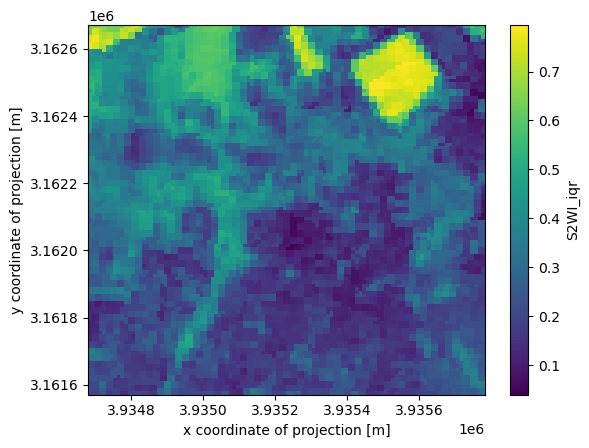

In [49]:
ts['S2WI_iqr'].plot(x='x', y='y')